In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [2]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]      
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [3]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_liver"
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 2010/2010 [01:37<00:00, 20.67it/s]


In [4]:
rate.shape

(18510, 16)

In [5]:
merged=pd.merge(quant,rate,left_on=['Peptide','Charge'],right_on=['Peptides','Charge'])
# merged=merged[merged['Rsquared']>0.9].reset_index(drop=True)
merged=merged.reset_index(drop=True)
quant=merged.copy()

In [6]:
# np.random.random(size=peptides.shape[0],min=0.01,max=0.05)

In [7]:
# peptides.to_csv("peptides.csv",index=False)

In [110]:
def getSimulationData(t):
       ph=1.5574E-4
       # k=0.035 
       # t=7
       np.random.seed(25)
       peptides=quant[['Peptide', 'Charge','Exchangeable Hydrogens', 
              'm/z(Sequence)_x', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5' ]]
       peptides=peptides.drop_duplicates()
       peptides.shape

       peptides['M0']=peptides['M0']/100
       peptides['M1']=peptides['M1']/100
       peptides['M2']=peptides['M2']/100
       peptides['M3']=peptides['M3']/100
       peptides['M4']=peptides['M4']/100
       peptides['M5']=peptides['M5']/100
       peptides['k']=np.random.uniform(low=0.01, high=0.05, size=peptides.shape[0])


       peptides['I0_asymp']= peptides.M0 * (  (1 - (0.015/(1-ph))) ** peptides['Exchangeable Hydrogens'] )
       peptides['I0_t_ln'] =  peptides['I0_asymp'] + ( peptides.M0 - peptides['I0_asymp'])*np.exp(-peptides['k']*t)
       # peptides['I0_t_exp']  = peptides.M0 - (peptides['k']*t) * ( peptides.M0 - peptides['I0_asymp']) 
       peptides['I0_t_exp']  = peptides['I0_asymp'] + ( peptides.M0 - peptides['I0_asymp'])*np.exp(-peptides['k']*t)


       rng1 = np.random.RandomState(32)
       rng2 = np.random.RandomState(42)


       io_0_noise=rng1.laplace(0.007944016223485617, 0.006262487876779792,peptides.shape[0])
       io_t_noise=rng2.laplace(0.007944016223485617, 0.006262487876779792,peptides.shape[0])

       peptides['I0_0_noise'] = peptides.M0 + io_0_noise
       peptides["I0_t_noise_ln"]= peptides['I0_t_ln'] +io_t_noise
       peptides["I0_t_noise_exp"]= peptides['I0_t_exp'] +io_t_noise 

       peptides['FSR_noise_ln'] = (peptides.I0_0_noise - peptides.I0_t_noise_ln)/ (peptides.I0_0_noise - peptides.I0_asymp)
       peptides['FSR_noise_exp'] = (peptides.I0_0_noise - peptides.I0_t_noise_exp)/ (peptides.I0_0_noise - peptides.I0_asymp)

       peptides['k_exp']= -np.log(1-peptides.FSR_noise_exp)/t
       peptides['k_ln']= peptides['FSR_noise_ln']/t


       peptides.head()
       return peptides


In [111]:
# # plt.hist(peptides.I0_t_noise-peptides.I0_t)
# plt.scatter(peptides.I0_t_exp,peptides.I0_t_noise_exp,c='k')
# plt.plot(peptides.I0_t_exp,peptides.I0_t_exp,c='r')

In [112]:
# plt.scatter(peptides.k,peptides.k_log_apr)
# plt.scatter(peptides.k,peptides.k_two_samp)

0.06851055037068904 0.0757555395277055 0.3898230379470059
0.25336285452038015 0.2655609905044864 0.2968024953187704


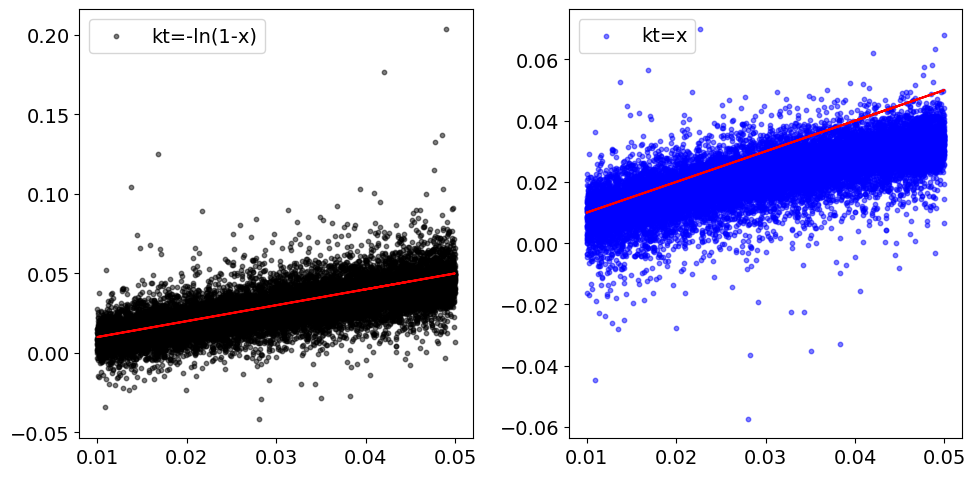

In [130]:

peptides=getSimulationData(t=15)

def plotRatesScatter(peptides,which=3):
    plt.rc("font",size=14)

    plt.figure(figsize=(10,5))
    if which == 1 or which ==3:
        plt.subplot(1,2,1)
        plt.scatter(peptides.k,peptides.k_exp,label="kt=-ln(1-x)",alpha=0.5,c='k',s=10)
        plt.plot(peptides.k,peptides.k,c='r')
        plt.legend()
    if which == 2 or which ==3:
        plt.subplot(1,2,2)
        plt.scatter(peptides.k,peptides.k_ln,label="kt=x",c='b',alpha=0.5,s=10)
        plt.plot(peptides.k,peptides.k,c='r')
        plt.legend()

    plt.tight_layout()
    # plt.savefig("scatter.jpeg",dpi=900)

    rd=(peptides.k-peptides.k_exp)/peptides.k
    print(np.nanmean(rd),np.nanmedian(rd),np.nanstd(rd))


    rd=(peptides.k-peptides.k_ln)/peptides.k
    print(np.nanmean(rd),np.nanmedian(rd),np.nanstd(rd))
    
plotRatesScatter(peptides)

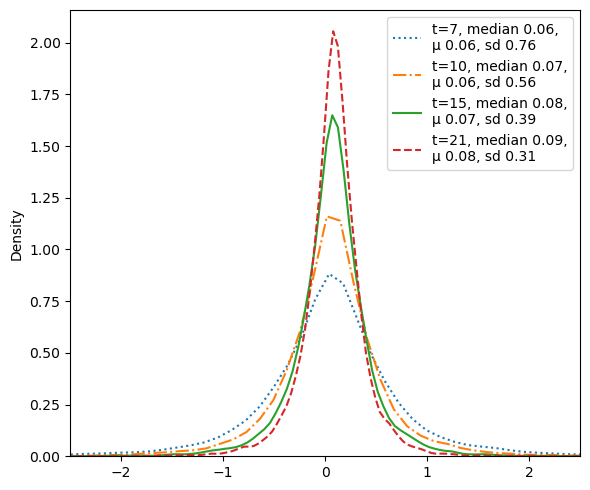

In [139]:
plt.figure(figsize=(6,5))
plt.rc("font",size=10) 
ls=[':','-.','-','--']
    
for i,t in enumerate([7,10,15,21]): 
    temp_data=getSimulationData(t=t)
    rd=(temp_data.k-temp_data.k_exp)/temp_data.k
    sns.kdeplot(rd,label=f"t={t}, median {np.nanmedian(rd):.2f},\nμ {np.nanmean(rd):.2f}, sd {np.nanstd(rd):.2f}",ls=ls[i])

plt.legend()
plt.xlim([-2.5,2.5])
plt.tight_layout()
plt.savefig("log_density.jpeg",dpi=900)
plt.show()


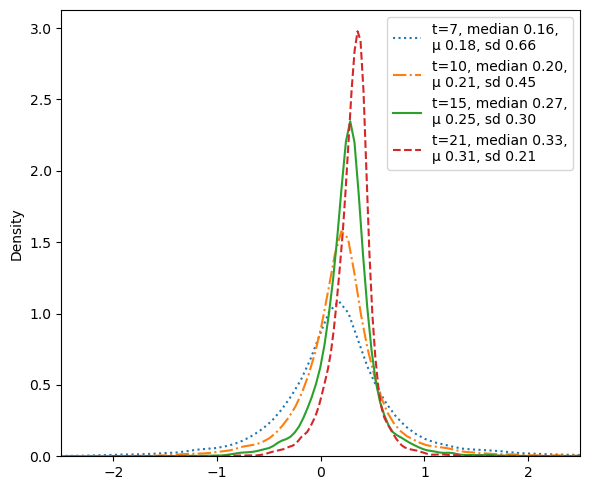

In [140]:
plt.figure(figsize=(6,5))
plt.rc("font",size=10) 
ls=[':','-.','-','--']
    
for i,t in enumerate([7,10,15,21]):   
    temp_data=getSimulationData(t=t)
    # temp_data=temp_data[(temp_data.k<0.35/t)& ( (temp_data.I0_0_noise - temp_data.I0_t_noise_ln)  >0.031)]
    rd=(temp_data.k-temp_data.k_ln)/temp_data.k 
    sns.kdeplot(rd,label=f"t={t}, median {np.nanmedian(rd):.2f},\nμ {np.nanmean(rd):.2f}, sd {np.nanstd(rd):.2f}",ls=ls[i])

plt.legend()
plt.xlim([-2.5,2.5])

plt.tight_layout()
plt.savefig("linear_density.jpeg",dpi=900)
# plt.savefig("linear_density_filtered.jpeg",dpi=900)

plt.show()


In [141]:
# plt.figure(figsize=(7,5))
# plt.rc("font",size=12)
# # plt.subplot(1,2,1)

# rd=(peptides.k-peptides.exp_k_log_apr_noise)/peptides.k
# sns.histplot(rd,kde=True,alpha=0.1,color='k',
#              label="kt=ln(1-x)"+f", mean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.std(rd):.2f}, ")
# # sns.histplot((peptides.k-peptides.k_two_samp_noise)/peptides.k,kde=False,label="kt=x",color='b',alpha=0.5)
# plt.legend()
# plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
# plt.xlim([-2,2])

# # plt.subplot(1,2,2)
# rd=(peptides.k-peptides.k_two_samp_noise)/peptides.k

# # sns.histplot((peptides.k-peptides.k_log_apr_noise)/peptides.k,kde=False,label="kt=ln(1-x)",alpha=0.5,color='k')
# sns.histplot(rd,kde=True,color='b',alpha=0.1,
#              label="kt=x"+f", mean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.std(rd):.2f}, ")
# plt.legend()
# plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
# plt.xlim([-2.5,2.5])

# plt.tight_layout()
# # plt.savefig(f"rate_Rd_{t}.jpeg",dpi=900)

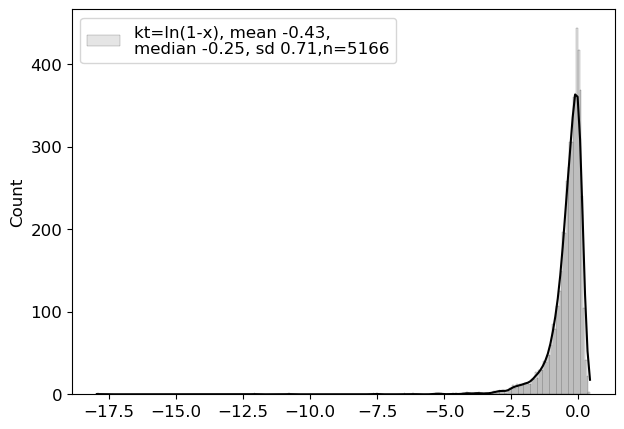

-0.42784034843388413 -0.2524974568239309 0.7062078251459948
-0.1908738515884943 -0.05963414302417827 0.49761045953937627


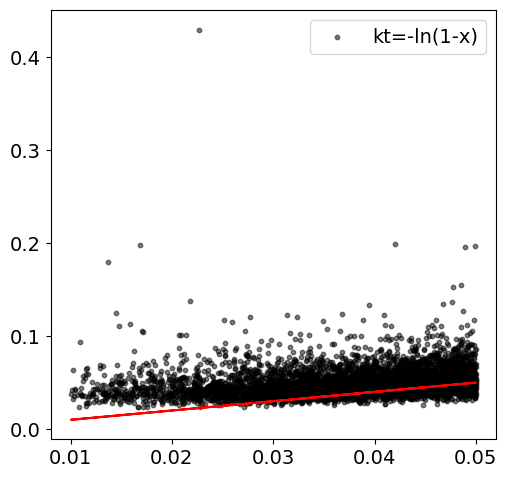

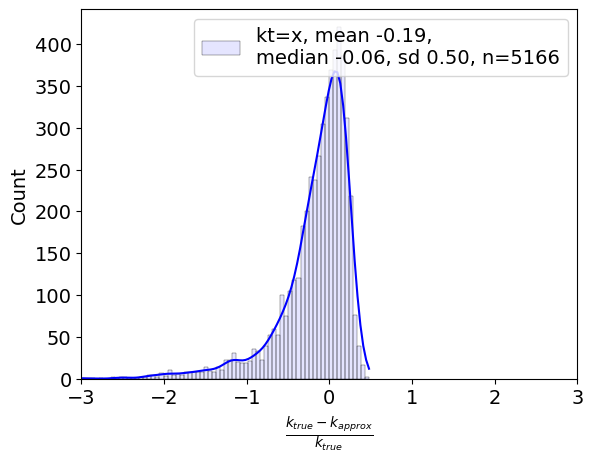

-0.42784034843388413 -0.2524974568239309 0.7062078251459948
-0.1908738515884943 -0.05963414302417827 0.49761045953937627


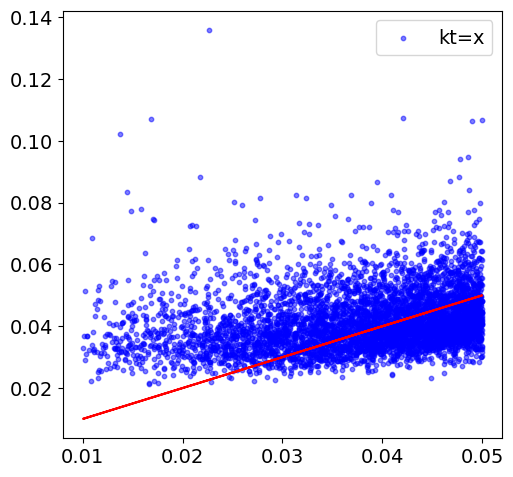

In [142]:
t=7
peptides=getSimulationData(t=t)

plt.figure(figsize=(7,5))
plt.rc("font",size=12) 

temp_data=peptides[(peptides.k<0.35/t)& ( (peptides.I0_0_noise - peptides.I0_t_noise_exp)  >0.031)]
rd=(temp_data.k-temp_data.k_exp)/temp_data.k
sns.histplot(rd,kde=True,alpha=0.1,color='k',
             label="kt=ln(1-x)"+f", mean {np.nanmean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.nanstd(rd):.2f},n={temp_data.shape[0]}")
plt.legend()
plt.show()

plotRatesScatter(temp_data,1)
plt.show()
# plt.subplot(1,2,2)
temp_data=peptides[(peptides.k<0.35/t)&(  (peptides.I0_0_noise - peptides.I0_t_noise_ln)  >0.031)]
rd=(temp_data.k-temp_data.k_ln)/temp_data.k 
sns.histplot(rd,kde=True,color='b',alpha=0.1,
             label="kt=x"+f", mean {np.nanmean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.nanstd(rd):.2f}, n={temp_data.shape[0]}")

plt.legend()
plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
plt.xlim([-3,3])

# plt.tight_layout()
# plt.savefig(f"rate_Rd_{t}.jpeg",dpi=900)
plt.show()

plotRatesScatter(temp_data,2)

In [690]:
# temp_data.iloc[100,:].k*t,temp_data.iloc[100,:].I0_t_d                       
# temp_data.iloc[100,:]

In [458]:
# # # peptides[['I0_t','I0_t_noise']]

# # plt.figure(figsize=(10,5))
# # plt.subplot(1,2,1)
# # sns.histplot((peptides.I0_t-peptides.I0_t_noise)/peptides.I0_t,kde=False,label="ln(1-x)",alpha=0.5,color='k') 
# # # plt.legend()
# # plt.xlabel(r"noise [rand.normal(meand=0,sd=0.5E-3)]")

# # plt.subplot(1,2,2)
# sns.histplot(peptides.I0_t_rd,color='green',alpha=0.4)
# plt.xlabel(r"$\frac{I_{0}(t)_{theo} - I_{0}(t)_{exp}}{I_{0}(t)_{theo}}$")

# plt.tight_layout()
# plt.savefig("addedNoise.jpeg",dpi=900)

In [459]:
# sns.histplot(peptides.k,kde=False,label="ln(1-x)",alpha=0.5,color='k')  
# plt.xlabel(r"turnover rates (k)")

# plt.tight_layout()
# plt.savefig("turnover_rates.jpeg",dpi=900)

In [273]:
# rd_log_apr_err=(peptides.k-peptides.k_log_apr_noise)/peptides.k
# plt.scatter(peptides.I0_t_rd,(peptides.k-peptides.k_log_apr_noise)/peptides.k,c='k',alpha=0.7)
# plt.vlines(x=0,ymin=min(rd_log_apr_err),ymax=max(rd_log_apr_err))
# plt.hlines(y=0,xmin=min(peptides.I0_t_rd),xmax=max(peptides.I0_t_rd))

In [ ]:
# rd_log_apr_err=(peptides.k-peptides.k_two_samp_noise)/peptides.k
# plt.scatter(peptides.I0_t_rd,(peptides.k-peptides.k_two_samp_noise)/peptides.k,c='k',alpha=0.7)
# plt.vlines(x=0,ymin=min(rd_log_apr_err),ymax=max(rd_log_apr_err))
# plt.hlines(y=0,xmin=min(peptides.I0_t_rd),xmax=max(peptides.I0_t_rd))